<a href="https://colab.research.google.com/github/songyoungoh/team_bassconnections_spring24/blob/main/models/CogVLM/CogVLM_AID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prelims



In [ ]:
!pip install torch==2.1.0 transformers==4.35.0 accelerate==0.24.1 sentencepiece==0.1.99 einops==0.7.0 xformers==0.0.22.post7 triton==2.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully unins

In [ ]:
import torch
import requests
from PIL import Image
from transformers import AutoModelForCausalLM, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained('lmsys/vicuna-7b-v1.5')
model = AutoModelForCausalLM.from_pretrained(
    'THUDM/cogvlm-chat-hf',
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
).to('cuda').eval()

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install accelerate`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# # vqa example
# # query = 'What is in this image?'
# query = "This image belongs to one of the following classifications: Annual Crop, Forest, Herbaceous Vegetation, Highway, Industrial, Pasture, Permanent Crop, Residential, River, Sea Lake. Identify which of the provided classifications you think the image belongs to."
# image = dataset[20000][0]
# inputs = model.build_conversation_input_ids(tokenizer, query=query, history=[], images=[image], template_version='vqa')   # vqa mode
# inputs = {
#     'input_ids': inputs['input_ids'].unsqueeze(0).to('cuda'),
#     'token_type_ids': inputs['token_type_ids'].unsqueeze(0).to('cuda'),
#     'attention_mask': inputs['attention_mask'].unsqueeze(0).to('cuda'),
#     'images': [[inputs['images'][0].to('cuda').to(torch.bfloat16)]],
# }
# gen_kwargs = {"max_length": 2048, "do_sample": False}

# with torch.no_grad():
#     outputs = model.generate(**inputs, **gen_kwargs)
#     outputs = outputs[:, inputs['input_ids'].shape[1]:]
#     print(tokenizer.decode(outputs[0]).replace("</s>", ""))

# # 4</s>

Residential


# Experiment 1

In [ ]:
import random
import pickle
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os
import glob
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

In [ ]:
def get_random_images(dataset_folder, sample_size=10):
    result_images = []
    categories = os.listdir(dataset_folder)
    category_size = max(1, sample_size // len(categories))

    for category in categories:
        category_path = os.path.join(dataset_folder, category)
        image_paths = glob.glob(os.path.join(category_path, '*.jpg')) + glob.glob(os.path.join(category_path, '*.png'))
        sampled_images = random.sample(image_paths, min(category_size, len(image_paths)))
        result_images.extend(sampled_images)

    return result_images

In [ ]:
def get_image_description(image_path):
    raw_image = Image.open(image_path).convert('RGB')
    query = "This image belongs to one of the following classifications: airport, bare land, baseball field, beach, bridge, center, church, commercial, dense residential, desert, farmland, forest, industrial, meadow, medium residential, mountain, park, parking, playground, pond, port, railway station, resort, river, school, sparse residential, square, stadium, storage tanks, viaduct. Identify which of the provided classifications you think the image belongs to."
    inputs = model.build_conversation_input_ids(tokenizer, query=query, history=[], images=[raw_image], template_version='vqa')   # vqa mode
    inputs = {
        'input_ids': inputs['input_ids'].unsqueeze(0).to('cuda'),
        'token_type_ids': inputs['token_type_ids'].unsqueeze(0).to('cuda'),
        'attention_mask': inputs['attention_mask'].unsqueeze(0).to('cuda'),
        'images': [[inputs['images'][0].to('cuda').to(torch.bfloat16)]],
    }
    gen_kwargs = {"max_length": 2048, "do_sample": False}

    with torch.no_grad():
        outputs = model.generate(**inputs, **gen_kwargs)
        outputs = outputs[:, inputs['input_ids'].shape[1]:]
        return tokenizer.decode(outputs[0]).replace("</s>", "")


# def visualize_accuracy(labels, predicted_classes, categories, i):
#     # Calculate accuracy for each category
#     category_accuracies = {category: 0 for category in categories}
#     for label, predicted_class in zip(labels, predicted_classes):
#         if label == predicted_class:
#             category_accuracies[label] += 1
#     # i = len(labels)
#     # Normalize accuracy to get percentages
#     total_images_per_category = len(labels) // len(categories)
#     category_accuracies = {category: accuracy / total_images_per_category * 100 for category, accuracy in category_accuracies.items()}

#     # Create a bar plot
#     plt.bar(category_accuracies.keys(), category_accuracies.values(), color='blue')
#     plt.xlabel('Categories')
#     plt.ylabel('Accuracy (%)')
#     plt.title('Accuracy for Each Category')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig(f"/content/drive/MyDrive/Fig/AID/accuracy{i}.png")
#     plt.show()


#     return category_accuracies

In [ ]:
def visualize_accuracy(labels, predicted_classes, categories, i):
    # Calculate accuracy for each category
    category_accuracies = {category: 0 for category in categories}
    for label, predicted_class in zip(labels, predicted_classes):
        if label == predicted_class:
            category_accuracies[label] += 1
    # Normalize accuracy to get percentages
    total_images_per_category = len(labels) // len(categories)
    category_accuracies = {category: accuracy / total_images_per_category * 100 for category, accuracy in category_accuracies.items()}

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.bar(category_accuracies.keys(), category_accuracies.values(), color='blue')
    plt.xlabel('Categories')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy for Each Category')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels and align them to the right
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Fig/AID/accuracy{i}.png")
    plt.show()

In [ ]:
# def plot_confusion_matrix(actual_classes, predicted_classes, i):
#     # Ensure unique labels are sorted or in a consistent order if necessary
#     labels = sorted(set(predicted_classes + actual_classes))
#     labels = [label[:20] for label in labels]  # Truncate label to no more than 20 characters
#     ConfusionMatrixDisplay.from_predictions(actual_classes, predicted_classes, display_labels=labels, xticks_rotation='vertical')
#     accuracy = accuracy_score(actual_classes, predicted_classes)
#     plt.tight_layout()
#     plt.title(f"Confusion Matrix {i} - Accuracy: {accuracy:0,.2f}")
#     plt.savefig(f'/content/drive/MyDrive/Fig/AID/confusionmatrix{i}.png')
#     plt.show()
#     return accuracy

In [ ]:
def plot_confusion_matrix(actual_classes, predicted_classes, i):
    # Ensure unique labels are sorted or in a consistent order if necessary
    labels = sorted(set(predicted_classes + actual_classes))
    labels = [label[:20] for label in labels]  # Truncate label to no more than 20 characters

    num_classes = len(labels)
    figsize = (min(20, num_classes * 0.5), min(20, num_classes * 0.5))  # Adjust based on number of classes

    accuracy = accuracy_score(actual_classes, predicted_classes)

    # plt.figure(figsize=figsize)  # Set the figure size
    cmp = ConfusionMatrixDisplay.from_predictions(actual_classes, predicted_classes, display_labels=labels, xticks_rotation='vertical')


    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(f"Confusion Matrix {i} - Accuracy: {accuracy:0,.2f}")
    fig.savefig(f'/content/drive/MyDrive/Fig/AID/confusionmatrix{i}.png')
    # fig.show()
    return accuracy

Predicted: ['beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'beach', 'center', 'railwaystation', 'railwaystation', 'denseresidential', 'industrial', 'railwaystation', 'industrial', 'railwaystation', 'industrial', 'railwaystation', 'railwaystation', 'railwaystation', 'denseresidential', 'railwaystation', 'railwaystation', 'industrial', 'industrial', 'railwaystation', 'railwaystation', 'railwaystation', 'railwaystation', 'railwaystation', 'railwaystation', 'rai

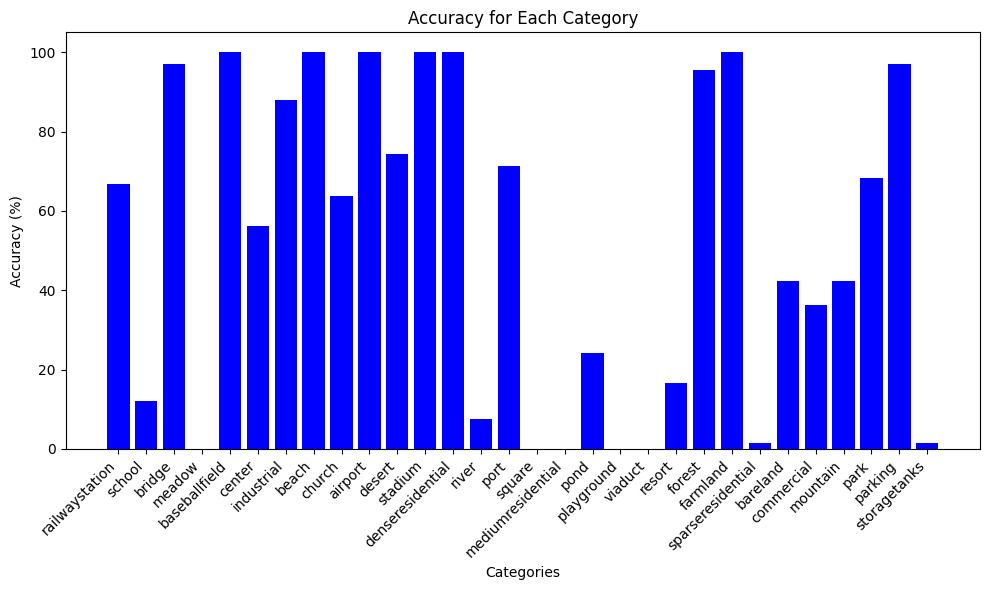

accuracy_conf: 0.5207070707070707


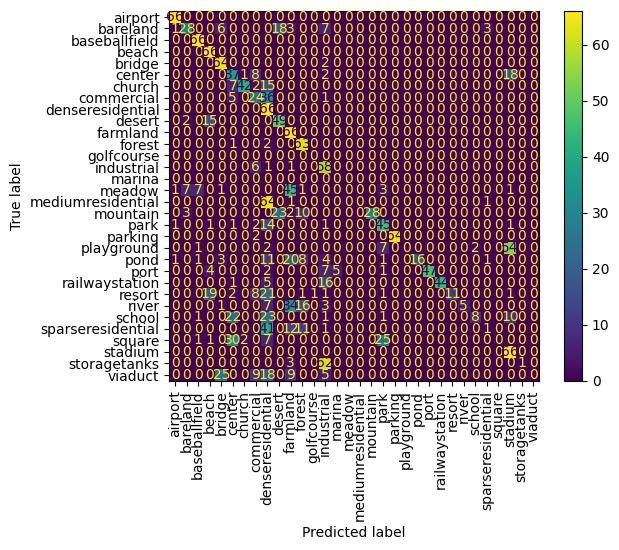

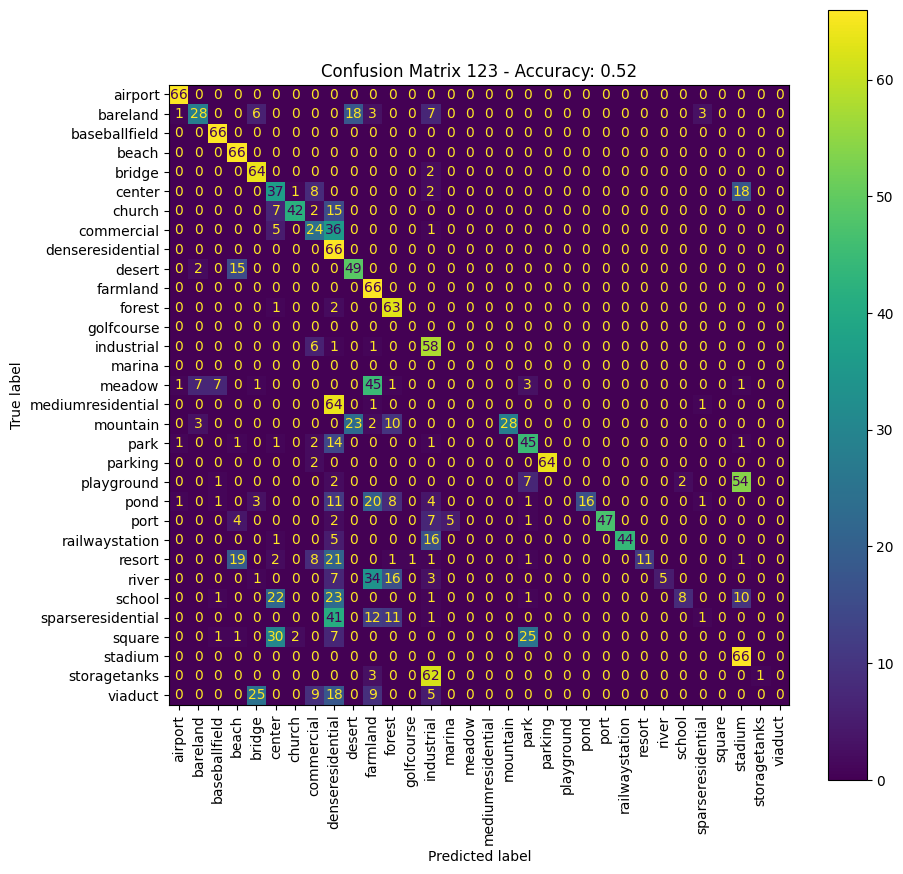

In [ ]:
dataset_folder = "/content/drive/MyDrive/Datasets/Train_Test_Splits_AID/train"
results_folder = "/content/drive/MyDrive/Results/AID"
sample_size = 2000 # minmum is 10 to get 1 image in each category
seed = 123
random.seed(seed)

# Get random images
random_images = get_random_images(dataset_folder, sample_size)
# Get labels
labels = [img.split('/')[-2].lower() for img in random_images]

# Get predicted classes from GPT-4
predicted_classes = [get_image_description(img).replace(' ', '') for img in random_images]
print("Predicted:", predicted_classes)
print("Acutal:", labels)

correct_count = sum(labels == predicted_classes for labels, predicted_classes in zip(labels, predicted_classes))
accuracy = correct_count/sample_size
print("Sample Size:", sample_size)
print("Accuracy:", accuracy)

# Visualize accuracy for each category
categories = set(labels)
category_accuracy = visualize_accuracy(labels, predicted_classes, categories, seed)

accuracy_conf = plot_confusion_matrix(labels, predicted_classes, seed)
print("accuracy_conf:", accuracy_conf)

# Save in dictionary
response_dict = dict(zip(random_images, predicted_classes))
with open(results_folder + f"/response_dict{seed}.pkl", 'wb') as file:
    pickle.dump(response_dict, file)

with open(results_folder + f"/cat_acc{seed}.pkl", 'wb') as file:
    pickle.dump(category_accuracy, file)

In [ ]:
dataset_folder = "/content/drive/MyDrive/Datasets/Train_Test_Splits_AID/train"
results_folder = "/content/drive/MyDrive/Results/AID"
sample_size = 2000 # minmum is 10 to get 1 image in each category
seed = 42
random.seed(seed)

# Get random images
random_images = get_random_images(dataset_folder, sample_size)
# Get labels
labels = [img.split('/')[-2].lower() for img in random_images]

# Get predicted classes from GPT-4
predicted_classes = [get_image_description(img).replace(' ', '') for img in random_images]
print("Predicted:", predicted_classes)
print("Acutal:", labels)

correct_count = sum(labels == predicted_classes for labels, predicted_classes in zip(labels, predicted_classes))
accuracy = correct_count/sample_size
print("Sample Size:", sample_size)
print("Accuracy:", accuracy)

# Visualize accuracy for each category
categories = set(labels)
category_accuracy = visualize_accuracy(labels, predicted_classes, categories, seed)

accuracy_conf = plot_confusion_matrix(labels, predicted_classes, seed)
print("accuracy_conf:", accuracy_conf)

# Save in dictionary
response_dict = dict(zip(random_images, predicted_classes))
with open(results_folder + f"/response_dict{seed}.pkl", 'wb') as file:
    pickle.dump(response_dict, file)

with open(results_folder + f"/cat_acc{seed}.pkl", 'wb') as file:
    pickle.dump(category_accuracy, file)

NameError: name 'random' is not defined